# Data exploration 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


## Data exploration
Let's look at some descriptive statistics of this dataset as well as the unique values for the categorical columns.

In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000,NaN,NaN,NaN,66.089,15.1631,0,57,66,77,100
reading score,1000,NaN,NaN,NaN,69.169,14.6002,17,59,70,79,100
writing score,1000,NaN,NaN,NaN,68.054,15.1957,10,57.75,69,79,100


In [7]:
columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for column in columns:
    print(f'{column}: {np.unique(df[column])}')

gender: ['female' 'male']
race/ethnicity: ['group A' 'group B' 'group C' 'group D' 'group E']
parental level of education: ["associate's degree" "bachelor's degree" 'high school' "master's degree"
 'some college' 'some high school']
lunch: ['free/reduced' 'standard']
test preparation course: ['completed' 'none']


## Outliers
Let's make box plots of the test scores to see if there are any outliers.

In [8]:
def stack_dataframe(df, column_list):
    df_stacked = df.loc[:, column_list].stack().copy()
    df_stacked.index = df_stacked.index.droplevel()
    df_stacked = df_stacked.reset_index().copy()
    df_stacked = df_stacked.rename(columns={'index': 'label', 0: 'value'})
    df_stacked = df_stacked.sort_values(by='label')
    df_stacked.index = np.arange(len(df_stacked))
    return df_stacked

In [9]:
def look_for_outliers(df, column_list):
    
    if len(column_list) > 1:
        df_stacked = stack_dataframe(df, column_list)
        sns.catplot(x='label', y='value', data=df_stacked, height=6, aspect=12/6, kind='box')
        plt.show()
    else:
        sns.catplot(y=column_list[0], data=df_clean, height=6, aspect=12/6, kind='box')
        plt.show()

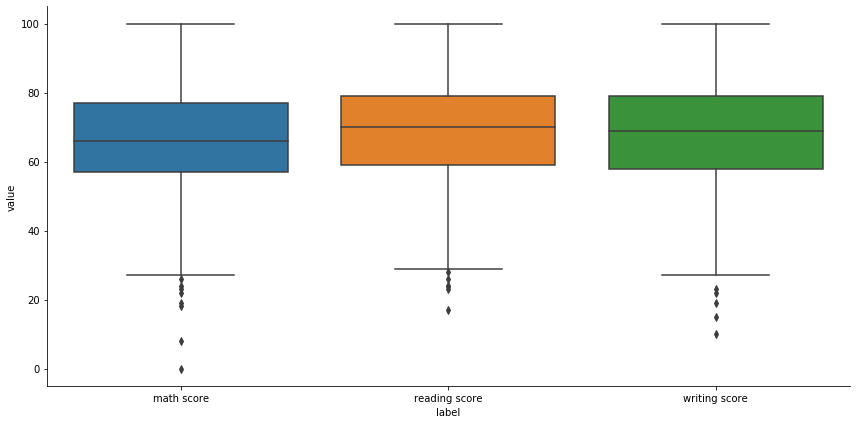

In [10]:
columns = ['math score', 'reading score', 'writing score']
look_for_outliers(df, columns)

I will use the Tukey method to remove the outliers seen at the lower end.

In [11]:
thresholds = {
    'tukey': 1.5
}

In [12]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [13]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
        
    return df

In [14]:
columns = ['math score', 'reading score', 'writing score']
df = correct_outliers(df, columns)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
tukey_math score               1000 non-null float64
tukey_reading score            1000 non-null float64
tukey_writing score            1000 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 86.0+ KB


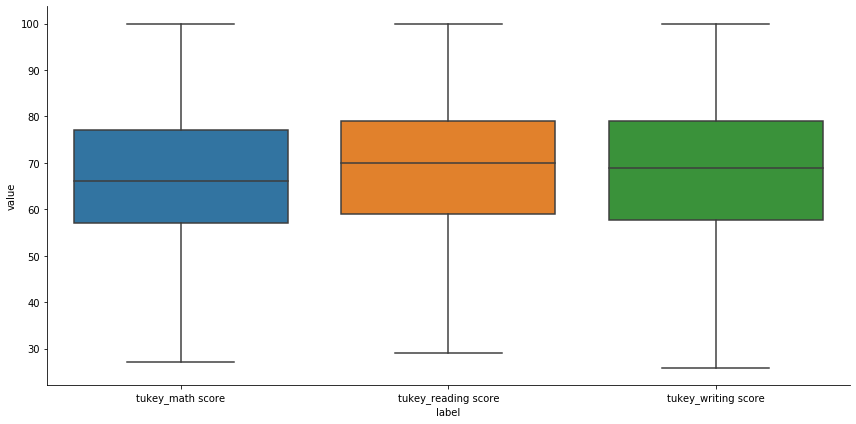

In [16]:
columns = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
look_for_outliers(df, columns)

## Demographic versus test score

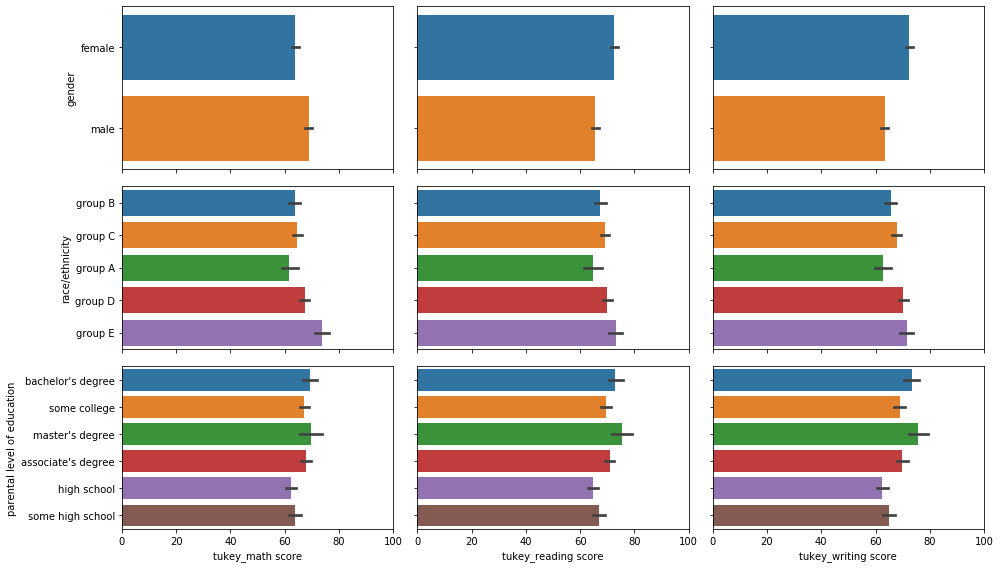

In [17]:
scores = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
categories = ['gender', 'race/ethnicity', 'parental level of education']

f, axes = plt.subplots(3, 3, figsize=(14, 8))

for i in range(len(categories)):
    for j in range(len(scores)):
        axes[i, j] = sns.barplot(x=scores[j], y=categories[i], data=df, ax=axes[i, j])
        axes[i, j].set_xlim([0, 100])
        if i < 2:
            axes[i, j].set_xlabel('')
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_ylabel('')
            axes[i, j].set_yticklabels([])

plt.tight_layout()
plt.show()

**Observations:**
* Gender:
    * Males performed better in math, while females performed better in reading and writing.
* Ethnic Group:
    * Group A performed worst across the board.
    * Group E performed best across the board.
* Education Level:
    * Those with a master degree performed best.
    * Those with only a high school education performed worst.

## Lunch type versus test score

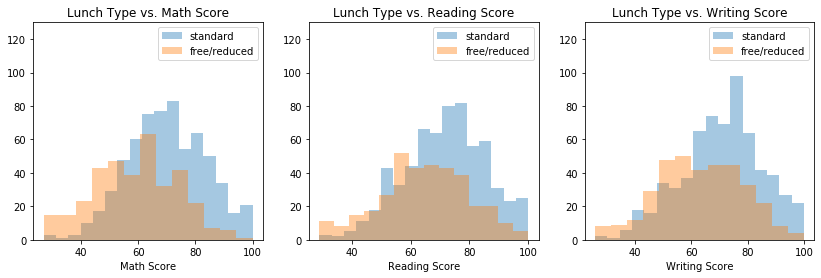

In [18]:
scores = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
score_labels = [x.split('_')[-1].title() for x in scores]
categories = ['lunch']

f, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, score_type in enumerate(scores):
    for lunch_type in df['lunch'].unique():
        sns.distplot(df.loc[df['lunch'] == lunch_type, score_type], ax=axes[i], kde=False)
    axes[i].legend(df['lunch'].unique())
    axes[i].set_xlabel(score_labels[i])
    axes[i].set_ylim([0, 130])
    axes[i].set_title(f'Lunch Type vs. {score_labels[i]}')
        
plt.show()

In [19]:
columns = ['tukey_math score', 'tukey_reading score', 'tukey_writing score', 'lunch']
temp = [x.split('_')[-1] for x in columns]
new_columns = [f'mean {x}' for x in temp]

old_to_new = {}
for i in range(len(new_columns)):
    old_to_new[columns[i]] = new_columns[i]

df_lunch_scores = df.loc[:, columns].groupby('lunch').mean()
df_lunch_scores.rename(columns=old_to_new, inplace=True)

In [20]:
df_lunch_scores

,mean math score,mean reading score,mean writing score
lunch,,,
free/reduced,59.112676,64.735211,63.125352
standard,70.046512,71.658915,70.829264


In [21]:
for score_type in scores:
    standard_lunch = df.loc[df['lunch'] == 'standard', score_type].values
    free_lunch = df.loc[df['lunch'] == 'free/reduced', score_type].values
    tstat, pval = stats.ttest_ind(standard_lunch, free_lunch)
    print(f"{score_type.split('_')[-1].title()}")
    print(f't-statistic = {tstat}, p-values = {pval}')

Math Score
t-statistic = 11.833770286241137, p-values = 2.5007581293356357e-30
Reading Score
t-statistic = 7.4163849841542175, p-values = 2.5677358016550227e-13
Writing Score
t-statistic = 7.9751217481785615, p-values = 4.150164241837491e-15


**Observations:** Those students who received a free or reduced lunch did not perform as well on the tests. They could come from less well off families and did not have the money to take the test preparation course.

## Test preparation course versus score

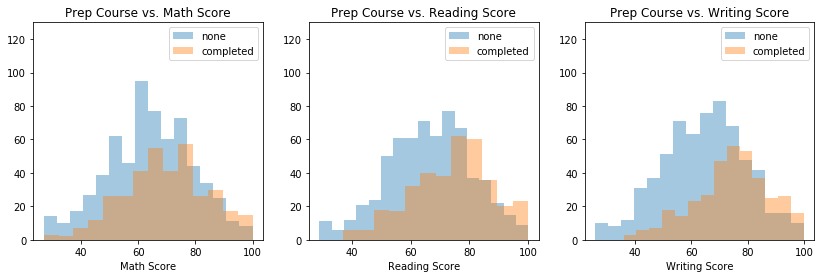

In [22]:
scores = ['tukey_math score', 'tukey_reading score', 'tukey_writing score']
score_labels = [x.split('_')[-1].title() for x in scores]
categories = ['test preparation course']

f, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, score_type in enumerate(scores):
    for lunch_type in df['test preparation course'].unique():
        sns.distplot(df.loc[df['test preparation course'] == lunch_type, score_type], ax=axes[i], kde=False)
    axes[i].legend(df['test preparation course'].unique())
    axes[i].set_xlabel(score_labels[i])
    axes[i].set_ylim([0, 130])
    axes[i].set_title(f'Prep Course vs. {score_labels[i]}')
        
plt.show()

In [23]:
for score_type in scores:
    no_course = df.loc[df['test preparation course'] == 'none', score_type].values
    completed_course = df.loc[df['test preparation course'] == 'completed', score_type].values
    tstat, pval = stats.ttest_ind(no_course, completed_course)
    print(f"{score_type.split('_')[-1].title()}")
    print(f't-statistic = {tstat}, p-values = {pval}')

Math Score
t-statistic = -5.692029799391047, p-values = 1.649724744686686e-08
Reading Score
t-statistic = -7.870411917143238, p-values = 9.167744509676495e-15
Writing Score
t-statistic = -10.432842972896616, p-values = 2.9443472863795566e-24


**Observations:** Those students who took the test preparation courses performed better on the test. This is logical since the course helped them learn the material they needed to pass the test.

In [24]:
df.loc[:, scores].corr()

,tukey_math score,tukey_reading score,tukey_writing score
tukey_math score,1.000000,0.815727,0.799954
tukey_reading score,0.815727,1.000000,0.954040
tukey_writing score,0.799954,0.954040,1.000000


**Observations:** The reading and writing scores have the highest correlation.